In [1]:
import numpy as np
from matplotlib import pyplot as plt 
from matplotlib import animation as am
from scipy.integrate import ode 


Bad key "text.kerning_factor" on line 4 in
/Users/yutingli/opt/anaconda3/envs/dde/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


# Set up the classes 

## The Kuramoto class is for 1D simulation and the Kuramoto2D class is for 2D simulations. 

In [15]:
class Kuramoto():
    
    def __init__(self, epsilon, gamma, sigma, mean_omega):
        # Initialises the class with the model parameters 
        self.epsilon = epsilon 
        self.gamma = gamma 
        self.sigma = sigma
        self.mean_omega = mean_omega 
        
    def initialise(self, L, T, dt, n_batches): 
        # Set up the simulation parameters 
        self.L = int(L) 
        self.size = int(L)
        self.T = T 
        self.dt = dt 
        self.n_batches = int(n_batches)
        self.step_size = T/(self.n_batches-1)
        self.batch_size = int(np.floor(self.step_size/self.dt))
        self.omegas = self.sigma*np.random.normal(size=(L)) + self.mean_omega 

    def evolve(self, verbose=False):
        # The core function that integrates the ODEs forward. 
        
        self.res = np.zeros((self.n_batches, self.size))
        theta = np.zeros((self.size))
        n = 0 
        
        small_batch = self.batch_size
        while small_batch > 1000:
            small_batch /= 10 # decrease the amount of time integration at each step
        
        f = lambda t, x: self._det_rhs(x)
        r = ode(f).set_integrator('lsoda', rtol=1e-5, nsteps=small_batch)
        r.set_initial_value(theta, 0)

        for i in range(int((self.T/self.dt)/small_batch)):
            if r.successful():
                if i % int(self.batch_size/small_batch) == 0:
                    self.res[n] = theta
                    if verbose: 
                        print("time step: {} \n".format(n))
                    n += 1
                theta = r.integrate(r.t+self.dt*small_batch)
        
    def _coupling(self, theta): 
        return np.sin(theta) + self.gamma*(1-np.cos(theta))

    def _det_rhs(self, theta): 
        d_theta_1 = np.roll(theta, 1) - theta 
        d_theta_2 = np.roll(theta, -1) - theta 
        rhs = self.epsilon*(self._coupling(d_theta_1)+self._coupling(d_theta_2))+self.omegas
        rhs[0] = 0 
        rhs[-1] = 0
        return rhs 
    
    
class Kuramoto2D(Kuramoto): 
    
    def initialise(self, Lx, Ly, T, dt, n_batches): 
        self.Lx = int(Lx)
        self.Ly = int(Ly)
        self.size = self.Lx*self.Ly 
        self.T = T 
        self.dt = dt 
        self.n_batches = int(n_batches)
        self.step_size = T/(self.n_batches-1)
        self.batch_size = int(np.floor(self.step_size/self.dt))
        self.omegas = self.sigma*np.random.normal(size=(Lx, Ly))
             
    def _det_rhs(self, theta): 
        theta = theta.reshape((self.Lx, self.Ly))
        d_thetas = [] 
        for d in [1, -1]:
            for a in [0, 1]: 
                d_thetas.append((np.roll(theta, d, axis=a) - theta))
                
        coupling = sum(map(self._coupling, d_thetas))
        rhs = self.epsilon*coupling + self.omegas
        rhs[0, :] = 0 
        rhs[-1, :] = 0 
        return rhs.flatten()

## First, we do some 1D simulations.  

In [25]:
# Set up model parameters 
epsilon = 1
gamma = 1
sigma = 0.2
mean_omega = 1 

# Set up simulation parameters 
L = 256 # size of the system 
T = 1e2 # total time of the simulation 
dt = 1e-2 # time step 
n_batches = 200 # number of time points recorded in the end 

# Initialise the model and run the simulation 
model = Kuramoto(epsilon, gamma, sigma, mean_omega)
model.initialise(L, T, dt, n_batches)
model.evolve(verbose=False) # this runs the simulation, set verbose to True to see output at every time step 

## Then, we plot the spacetime graph of the phase evolution 

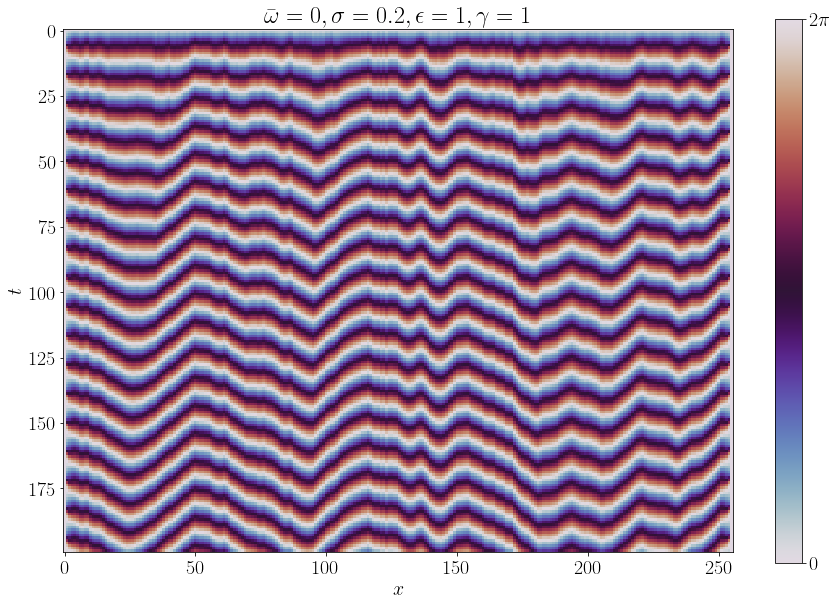

In [26]:
plt.figure(figsize=(15, 10))
plt.rc('font', size=20)
plt.rc('text', usetex=True)
im = plt.imshow(model.res % (np.pi*2), cmap='twilight', vmin=0, vmax=2*np.pi)
cbar = plt.colorbar(im)
cbar.set_ticks([0, 2*np.pi])
cbar.set_ticklabels([r'$0$', r'$2\pi$'])
plt.title(r'$\bar{{\omega}}={}, \sigma={}, \epsilon ={}, \gamma ={}$'.format(0, sigma, epsilon, gamma))
plt.xlabel(r'$x$')
plt.ylabel(r'$t$')
plt.show() 

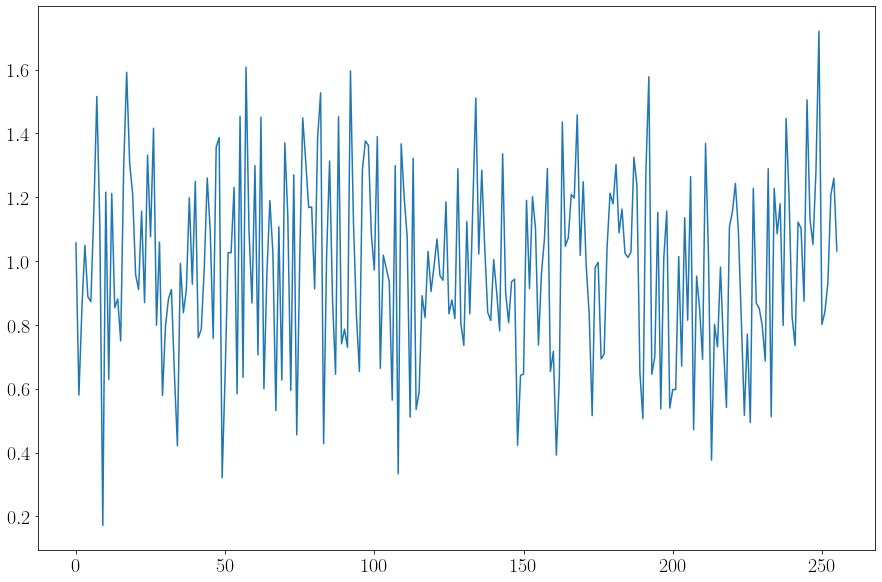

In [20]:
plt.figure(figsize=(15, 10))
plt.plot(model.omegas)
plt.show() 

## Next, we set up and run some 2D simulations 

In [23]:
# Set up model parameters 
epsilon = 1 
gamma = 1
sigma = 0.3
mean_omega = 1 

# Set up simulation parameters 
Lx = 128
Ly = 20
T = 1e2
dt = 1e-2
n_batches = 100 

# Initialise the model and run the simulation 
model = Kuramoto2D(epsilon, gamma, sigma, mean_omega)
model.initialise(Lx, Ly, T, dt, n_batches)
model.evolve() 

## Make movie of the 2D simulation 

In [24]:
# Reshape the result into 2D shape 
phase_evolution = model.res.reshape((model.n_batches, model.Lx, model.Ly))

# Set up figure plotting 
fig = plt.figure(figsize=(20, 5))
low, high = 0, 2*np.pi 

plt.rc('font', size=20)
plt.rc('text', usetex=True)

# Plot the movie one snapshot at a time 
ims = []
im = plt.imshow(phase_evolution[0].T, vmin=low, vmax=high, animated=True, cmap='twilight')
plt.title(r'$\sigma={}, \epsilon ={}, \gamma ={}$'.format(sigma, epsilon, gamma))
plt.axis('off')
cbar = plt.colorbar(im, shrink=0.6)
cbar.set_ticks([0, 2*np.pi])
cbar.set_ticklabels([r'0', r'$2\pi$'])
plt.tight_layout()
for i in range(model.n_batches):
    xy = phase_evolution[i].T % 2*np.pi 
    im = plt.imshow(xy, vmin=low, vmax=high, animated=True, cmap='twilight')
    plt.axis('off')
    ims.append([im])
ani = am.ArtistAnimation(fig, ims, interval=100, blit=True,
                                repeat_delay=1000)
mywriter = am.FFMpegWriter()
ani.save("movie.mp4", writer=mywriter)
plt.close()


## Now you will find a video called "movie.mp4" in the same folder